In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x1 = np.array([-1, -1, -1])
x2 = np.array([1, -1, 1])
x3 = np.array([-1, 1, 1])
x4 = np.array([1, 1, -1])
x5 = np.array([1, 1, 1])
x6 = np.array([1, -1, -1])
x7 = np.array([-1, 1, -1])
x8 = np.array([-1, -1, 1])

p = np.array([x1, x2, x3, x4, x5, x6, x7, x8])
p_d = np.array([1/4, 1/4, 1/4, 1/4, 0, 0, 0, 0])

In [3]:
def stochastic_update(b):
    random_numbers = np.random.uniform(0,1, size = (b.shape))
    b = 1/(1+np.exp(-2*b))
    return np.where(random_numbers < b, 1 , -1)

In [4]:
def rbm_training(w, theta_v, theta_h, trials, mini_batch, cd_k, eta, hidden_neurons, pattern = p):
    #Loop over trials
    for _ in range(trials):
        delta_w = np.zeros((hidden_neurons, 3))
        delta_theta_v = np.zeros((1,3))
        delta_theta_h = np.zeros((hidden_neurons,1))
        
        #Loop over mini batches
        for _ in range(mini_batch):

            #Pick a random pattern
            random_pattern = np.random.randint(0,4)
            v= p[random_pattern].reshape(1,3)
            v_0 = p[random_pattern].reshape(1,3)

            b_h = np.subtract(np.dot(w, v.T), theta_h)
            b_h_0 = np.subtract(np.dot(w, v.T), theta_h)
            h = stochastic_update(b_h)

            #Loop over CD_k
            for _ in range(cd_k):

                b_v = np.subtract(np.dot(h.T, w), theta_v)
                v = stochastic_update(b_v)

                b_h = np.subtract(np.dot(w, v.T), theta_h)
                h = stochastic_update(b_h)

            delta_w += eta * (np.tanh(b_h_0) * v_0 - np.tanh(b_h) * v) 
            delta_theta_v -= eta * (v_0 - v)
            delta_theta_h -= eta * (np.tanh(b_h_0) - np.tanh(b_h))

        w += delta_w
        theta_v += delta_theta_v
        theta_h += delta_theta_h
    return w, theta_v, theta_h

In [5]:
def rbm_test(w, theta_v, theta_h, n_out, n_in, pattern = p):

    p_b = np.array([0,0,0,0,0,0,0,0], dtype=float)
    
    for _ in range(n_out):

        random_pattern = np.random.randint(0,8)

        x = p[random_pattern].reshape(1,3)
        b_h = np.subtract(np.dot(w, x.T), theta_h)
        h = stochastic_update(b_h)

        for _ in range(n_in):

            b_v = np.subtract(np.dot(h.T, w), theta_v)
            v = stochastic_update(b_v)

            b_h = np.subtract(np.dot(w, v.T), theta_h)
            h = stochastic_update(b_h)

            pattern = int(np.where([np.array_equal(p[i], v[0]) for i in range(8)])[0])
            p_b[pattern] += 1/(n_out*n_in)
    
    log_p_b = np.log(p_b, out = np.zeros_like(p_b), where = (p_b != 0))
    log_p_d = np.log(p_d, out = np.zeros_like(p_d), where = (p_d != 0))
    delta_d_kl = np.dot(p_d, np.subtract(log_p_d, log_p_b))
    
    return delta_d_kl

In [9]:
m = [1, 2, 4, 8]
np.set_printoptions(suppress=True)
m_dim = []
for i in range(len(m)):
    hidden_neurons = m[i]
    w = np.random.normal(0,1, size = (hidden_neurons, 3))
    theta_v = np.zeros((1,3))
    theta_h = np.zeros((hidden_neurons,1))
    list_dkl = []
    
    print('Dimension m:', hidden_neurons)
    for _ in range(5):
        w, theta_v, theta_h = rbm_training(w, theta_v, theta_h, trials = 100, mini_batch = 20, cd_k = 200, eta = 0.005, hidden_neurons = hidden_neurons)
        delta_d_kl = rbm_test(w, theta_v, theta_h, n_out = 1000, n_in = 1000)
        list_dkl.append(delta_d_kl)
        print(delta_d_kl)
    m_dim.append(list_dkl)


Dimension m: 1
0.7098916158155216
0.7017289653251189
0.6983699059987657
0.6967598073106058
0.6976513100790115
Dimension m: 2
0.5393180324376419
0.4812650324086118
0.41977101791981436
0.42250787530121453
0.44484892230622314
Dimension m: 4
0.26385347978356705
0.11643517066020304
0.11999251998263938
0.0731078763869712
0.0292911696371575
Dimension m: 8
0.12785520258648253
0.058704944251912805
0.08319103925830434
0.09068759198586396
0.03439077626808362


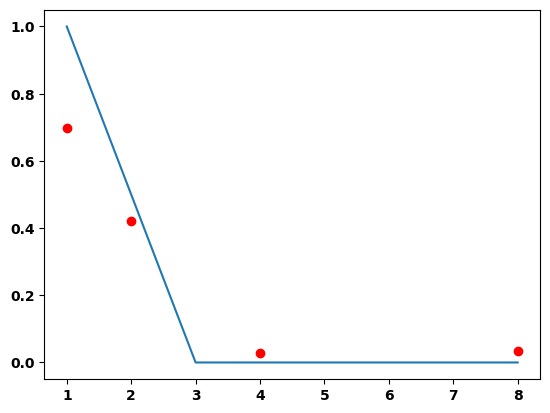

In [13]:
plt.plot(m, np.min(m_dim, axis=1), 'ro')
n = 3
theory = []
for j in range(1,9):
    if j < 2**(n-1)-1:
        theory.append(n - np.floor(np.log2((j+1))) - np.divide((j+1),2**np.floor(np.log2((j+1)))))
    else : 
        theory.append(0)

x = [1,2,3,4,5,6,7,8]
plt.plot(x, theory)